In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import koreanize_matplotlib  # 한글 폰트 적용

# 하이퍼파라미터
input_size = 28      # 한 행의 픽셀 수
sequence_length = 28 # 시퀀스 길이 = 행 개수
hidden_size = 128    # LSTM 은닉 상태 크기
num_layers = 1       # LSTM 층 수
num_classes = 10     # 분류 클래스 (0~9)
batch_size = 64
num_epochs = 10
learning_rate = 0.001

# 데이터셋 전처리
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [2]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):  # 입력 x: [batch, 1, 28, 28]
        x = x.squeeze(1)   # 채널 제거 → [batch, 28, 28]
        out, (hn, cn) = self.lstm(x)  # LSTM 수행
        out = self.fc(hn[-1])         # 마지막 hidden state만 사용 → 분류
        return out



In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMClassifier(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [4]:
train_losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # 순전파
        outputs = model(images)
        loss = criterion(outputs, labels)

        # 역전파 및 최적화
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/10], Loss: 0.3626
Epoch [2/10], Loss: 0.1011
Epoch [3/10], Loss: 0.0696
Epoch [4/10], Loss: 0.0575
Epoch [5/10], Loss: 0.0429
Epoch [6/10], Loss: 0.0387
Epoch [7/10], Loss: 0.0309
Epoch [8/10], Loss: 0.0298
Epoch [9/10], Loss: 0.0241
Epoch [10/10], Loss: 0.0201


In [5]:
model.eval()
correct = 0
total = 0
wrong_samples = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # 오답 샘플 저장 (최대 10개)
        for img, pred, label in zip(images, predicted, labels):
            if pred != label and len(wrong_samples) < 10:
                wrong_samples.append((img.squeeze().cpu().numpy(), pred.item(), label.item()))

accuracy = 100 * correct / total
print(f"LSTM 기반 모델의 테스트 정확도: {accuracy:.2f}%")

LSTM 기반 모델의 테스트 정확도: 98.45%


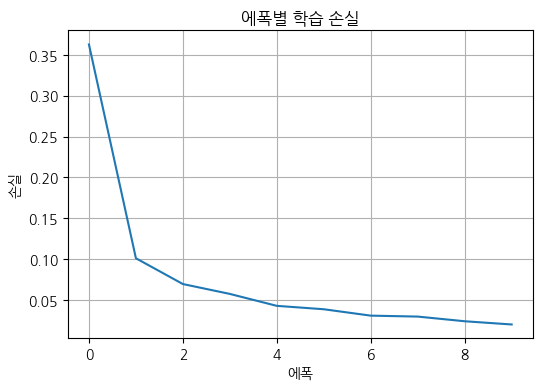

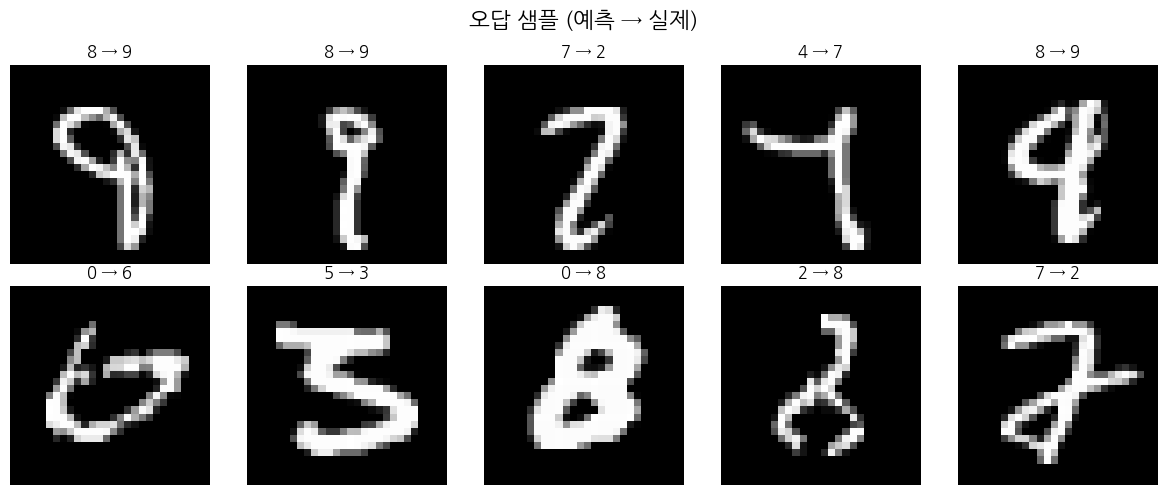

In [6]:
# 학습 손실 곡선
plt.figure(figsize=(6, 4))
plt.plot(train_losses)
plt.title("에폭별 학습 손실")
plt.xlabel("에폭")
plt.ylabel("손실")
plt.grid(True)
plt.show()

# 오답 시각화
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle("오답 샘플 (예측 → 실제)", fontsize=16)

for ax, (img, pred, label) in zip(axs.flat, wrong_samples):
    ax.imshow(img, cmap='gray')
    ax.set_title(f"{pred} → {label}")
    ax.axis('off')

plt.tight_layout()
plt.show()